In [1]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC
import matplotlib.pyplot as plt

# INF 554 Lab 5: Support Vector Machines and Non-Negative Matrix Factorisation


In this lab we will be working with support vector machines (SVMs), which are a supervised learning method for data classification, and the non-negative matrix factorisation (NMF) algorithm, which is an unsupervised method for feature extraction, i.e., dimension reduction of our dataset.  


## 1) Support Vector Machines


We begin with an incomplete introduction to the mathematics underpinning support vector machines (SVMs). The aim of this introduction is not for you to follow the derivation of support vector machines step by step, but rather for you to get an insight into the quantities which are involved in the derivation of SVMs, so that you are able to conceptually interpret the results we obtain in  this lab.

We denote our data by $x_i \in R^p$ with two-class class labels defined by $y_i \in \{-1,1\}$ for $i\in \{1,\ldots, n\}.$ Now we define a hyperplane in the data space by 
$$
\{x: f(x) = x^T\beta + \beta_0 = 0\}, \hspace{1.5cm}(1)
$$
where $||\beta||=1,$ so that $f(x)$ is equal to the signed distance of point $x$ to the hyperplane described in Equation (1). Such a hyperplane can be used as a classification rule by assigning data point $x^\star$ the label
$$
y^\star  = \text{sign}(x^{\star~T}\beta + \beta_0).
$$

SVMs search for the hyperplane, which optimally separates the two classes by maximising the *margin* $M$ from the hyperplane to the nearest datapoint of the two classes, i.e., 
\begin{align}
\max_{\beta, \beta_0, ||\beta||=1} &M \\
\text{subject to  } & y_i (x^T\beta + \beta_0 ) >M \quad \text{ for } i \in \{1, \ldots, n\}.
\end{align}

This problem is equivalent to the following (Hastie et al., 2008,p.132),
\begin{align}
\min_{\beta, \beta_0} &||\beta|| \\
\text{subject to  } & y_i (x^T\beta + \beta_0 ) >1 \quad \text{ for } i \in \{1, \ldots, n\}.
\end{align}

Now this optimisation works under the assumption that our two classes are linearly separable. This assumption is often violated and therefore we introduce slack variables $\xi_i,$ which are used to relax the optimisation constraint to the following $y_i (x^T\beta + \beta_0 ) >1-\xi_i.$ We restrict these slack variables to sum to a value less than a constant $C'$, which we will be able to choose based on the amount of overlap of our classes. Solving the optimisation problem including the slack variables $\xi$ is done by considering the following equivalent form,
\begin{align}
\min_{\beta, \beta_0} &\frac{1}{2}||\beta||^2 + C \sum_{i=1}^n \xi_i \\
\text{subject to  } & \xi_i \geq 0 \text{  and  } y_i (x^T\beta + \beta_0 ) \geq 1-\xi_i \quad \text{ for } i \in \{1, \ldots, n\}.
\end{align}

Hence, large values of $C$ discourage large slack variables $\xi_i$, while small values of $C$ allow the optimal solution to this problem to liberally use the slack variables $\xi_i.$ This optimisation problem is solved by using Lagrange multipliers $\alpha_i,$ which leads to the following dual objective function,
\begin{align}
\max_{\alpha} &\sum_{i=1}^n \alpha_i - \frac{1}{2} \sum_{i,j=1}^n \alpha_i \alpha_j y_i y_j  x_i^Tx_j \hspace{1.5cm}(2) \\
\text{subject to  } & 0 \leq \alpha_i \leq C \text{  and  } \sum_{i=1}^n\alpha_i y_i= 0  \quad \text{ for } i \in \{1, \ldots, n\}.
\end{align}
When solving this optimisation problem we obtain optimal $\hat{\alpha}$'s, which are non-zero only for certain data points $x_i,$ which satisfy $y_i (x_i^T\beta + \beta_0 ) -(1-\xi_i)=0,$ i.e., those data points which lie exactly on their margin minus its slack value. The optimal hyperplane parameters ($\hat{\beta} = \sum_{i=0}^n \hat{\alpha}_i y_i x_i$) are only calculated on the basis of data points for which $\hat{\alpha}>0$ and hence, these data points are called *support vectors.*





This introduction to SVMs is based on their description in Hastie et al.'s book "Elements of Statistical Learning." If you would like a deeper understanding of SVMs or many other statistical algorithms we recommend you to take a look at the free version of the book available here: https://web.stanford.edu/~hastie/Papers/ESLII.pdf.








### Kernel Functions

Note that the cost function in optimisation problem (2) only depends on the data points via their inner product. Hence, we are able to use what is called the "kernel trick" and replace this inner product with any other kernel we like. This allows us to consider distances of data points in higher dimensional spaces in which the data points may be better separated. Finding a sensible kernel is often a difficult problem and they are typically selected or designed using specific knowledge of the problem domain. Usually a good first question to ask is whether we even need a non-linear kernel. 

In this lab we will be working with two different kernel functions. Firstly, the obvious choice, the linear kernel,
\begin{equation}
  K_{lin}(x_i, x_j) = x_i^T x_j.
\end{equation}

We will furthermore be working with the Gaussian kernel, which will allow us to fit non-linear decision boundaries. The Gaussian kernel is parameterised by a bandwidth parameter, $\sigma$, which determines how fast the similarity metric decreases (toward $0$) as the input data points are further apart. The Gaussian kernel is defined as follows,
\begin{equation}
  K_{Gauss}(x_i, x_j) = \exp\left( - \frac{\| x_i - x_j\|^2}{2 \sigma^2}\right).
\end{equation}




Below, we have implemented these kernel functions for you. 


In [2]:
def linearKernel(X1, X2):
    """
    Args:
        X1 (np.array, n_1 x p): a set of n  datapoints to be used as the first of the two kernel inputs
        X2 (np.array, n_2 x p): a set of n  datapoints to be used as the second of the two kernel inputs
    
    Returns:
        K (np.array, n_1 x n_2): a kernel matrix containing the kernel values measuring of all possible data point pairs
    """    
    K = np.zeros((X1.shape[0],X2.shape[0]))
    
    K = X1 @ X2.T
    
    return K

 
def gaussianKernel(X1, X2, sigma = 0.1):
    """
    Args:
        X1 (np.array, n_1 x p): a set of n  datapoints to be used as the first of the two kernel inputs
        X2 (np.array, n_2 x p): a set of n  datapoints to be used as the second of the two kernel inputs
    
    Returns:
        K (np.array, n_1 x n_2): a kernel matrix containing the kernel values measuring of all possible data point pairs
    """    
    K = np.zeros((X1.shape[0],X2.shape[0]))
     
    for i in range(X1.shape[0]):
        K[i,:] = np.exp(-(np.linalg.norm(X1[i,:]-X2, axis=1)**2)/(2*sigma**2))
     
    return K

### Dataset 1

We will begin with a simple dataset which is linear separable. In this dataset, the positions of the positive examples (indicated with +) and the negative examples (indicated with x) suggest a natural separation indicated by the gap. However, notice that there is an outlier positive example o on the far left at about $(0.1, 4.1)$. As part of this exercise, you will see how  this outlier affects the SVM decision boundary.

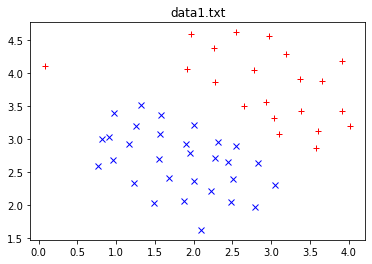

In [3]:
# Load the dataset
fname='data1.txt'
data = np.loadtxt('data/%s' % fname, delimiter=',')
 
X = data[:, 0:2] 
y = data[:, 2]
 
# Plot data 
plt.plot(X[:,0][y == 1], X[:,1][y == 1], 'r+')
plt.plot(X[:,0][y == 0], X[:,1][y == 0], 'bx')
plt.title(fname)
plt.show()




>**Task 1:** Use the [scikit learn SVC function](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC) with a "precomputed" kernel using our preimplemented linearKernel function to fit an SVM to data set 1. Experiment with different values of C and observe how they affect the classification accuracy and decision boundary.




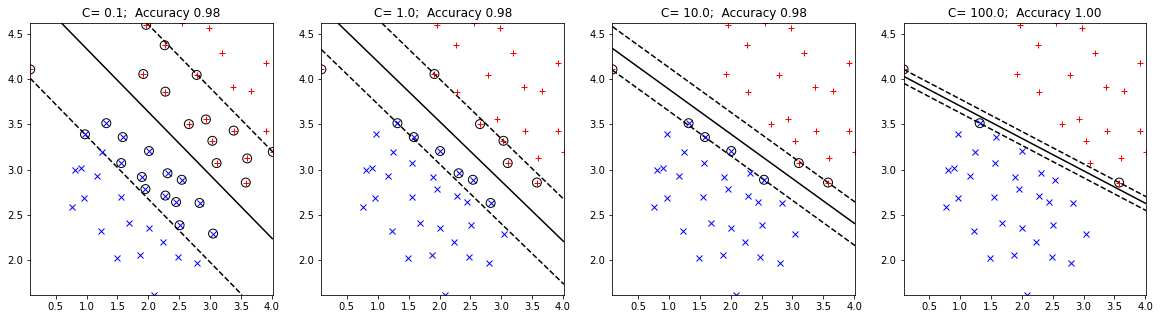

In [4]:
C = [0.1, 1, 10, 100] #Please insert your code for Task 1 here


fig, ax = plt.subplots(nrows=1, ncols=len(C), figsize=(max(5*len(C),5),5))


for index, c in enumerate(C):

    #Please insert your code for Task 1 here (Please call your model object "svc")
    svc = SVC(C = c, kernel = "precomputed")
    svc.fit(linearKernel(X,X),y)


    # Calculate the decision function within the support of our data points:
    u = np.linspace(min(X[:, 0]),max(X[:, 0]), 200)
    v = np.linspace(min(X[:, 1]),max(X[:, 1]), 200)
    z = np.zeros(shape=(len(u), len(v)))
    for i in range(len(u)):
        for j in range(len(v)):
            x = np.array([[u[i],v[j]]])
            z[i, j] = svc.decision_function(linearKernel(x,X))


    ax[index].plot(X[:,0][y == 1], X[:,1][y == 1], 'r+', label="$y=1$")
    ax[index].plot(X[:,0][y == 0], X[:,1][y == 0], 'bx', label="$y=0$")
    ax[index].scatter(X[svc.support_, 0], X[svc.support_, 1], s=80, facecolors='none', zorder=10, edgecolor='k')
    ax[index].contour(u, v, z.T, levels = [-1,0,1], colors='k',linestyles=['--', '-', '--'])
    ax[index].title.set_text('C= %0.1f;  Accuracy %0.2f' %(c, np.sum(svc.predict(linearKernel(X,X)) == y)/len(y)))
plt.show()

### Dataset 2
Now, we are going to use SVMs for non-linear classification. More specifically, you will be using SVMs along with Gaussian kernels on datasets where classes are not linearly separable. From the plot of the dataset, it is apparent that there is no linear decision boundary that separates the two classes in this dataset. However, by using the Gaussian kernel with the SVM, you will be able to learn a non-linear decision boundary.

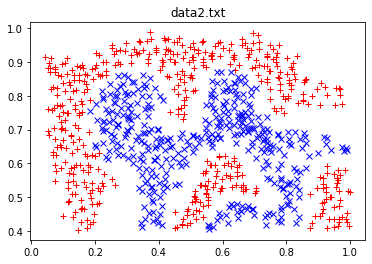

In [5]:
# Load the dataset
fname='data2.txt'
data = np.loadtxt('data/%s' % fname, delimiter=',')
 
X = data[:, 0:2] 
y = data[:, 2]
 
# Plot data 
plt.plot(X[:,0][y == 1], X[:,1][y == 1], 'r+')
plt.plot(X[:,0][y == 0], X[:,1][y == 0], 'bx')
plt.title(fname)
plt.show()

>**Task 2:** Use the [scikit learn SVC function](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC) with "precomputed" kernels using both our preimplemented linearKernel and gaussianKernel functions to fit an SVM to data set 2. Experiment with different values of $\sigma$ in the Gaussian kernel and observe how they affect the classification accuracy and decision boundary. What is the highest accuracy you are able to achieve and what weaknesses do you think might the model achieving maximum accuracy have?



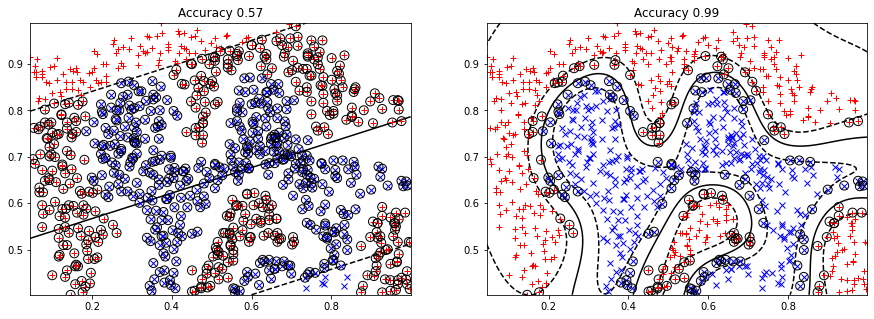

In [6]:
#Please insert your code for Task 2 here (Please call your model object "svc_linear" and "svc_gaussian")
C = [0.1,1,10,100]
sigma_values = [0.01, 0.1, 0.5]

sigma = sigma_values[1]

svc_linear = SVC(C=C[1], kernel = "precomputed")
svc_linear.fit(linearKernel(X,X), y)

svc_gaussian =  SVC(C=C[1], kernel = "precomputed")
svc_gaussian.fit(gaussianKernel(X, X, sigma), y)


# Plot the decision boundary
u = np.linspace(min(X[:, 0]),max(X[:, 0]), 200)
v = np.linspace(min(X[:, 1]),max(X[:, 1]), 200)
z_linear = np.zeros(shape=(len(u), len(v)))
z_gaussian = np.zeros(shape=(len(u), len(v)))
for i in range(len(u)):
    for j in range(len(v)):
        x = np.array([[u[i],v[j]]])
        z_linear[i, j] = svc_linear.decision_function(linearKernel(x,X))
        z_gaussian[i, j] = svc_gaussian.decision_function(gaussianKernel(x,X,sigma))

        
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
ax[0].plot(X[:,0][y == 1], X[:,1][y == 1], 'r+', label="$y=1$")
ax[0].plot(X[:,0][y == 0], X[:,1][y == 0], 'bx', label="$y=0$")
ax[0].scatter(X[svc_linear.support_, 0], X[svc_linear.support_, 1], s=80, facecolors='none', zorder=10, edgecolor='k')
ax[0].contour(u, v, z_linear.T, levels = [-1,0,1], colors='k',linestyles=['--', '-', '--'])
ax[0].title.set_text('Accuracy %0.2f' %(np.sum(svc_linear.predict(linearKernel(X,X)) == y)/len(y)))

ax[1].plot(X[:,0][y == 1], X[:,1][y == 1], 'r+', label="$y=1$")
ax[1].plot(X[:,0][y == 0], X[:,1][y == 0], 'bx', label="$y=0$")
ax[1].scatter(X[svc_gaussian.support_, 0], X[svc_gaussian.support_, 1], s=80, facecolors='none', zorder=10, edgecolor='k')
ax[1].contour(u, v, z_gaussian.T, levels = [-1,0,1], colors='k',linestyles=['--', '-', '--'])
ax[1].title.set_text('Accuracy %0.2f' %(np.sum(svc_gaussian.predict(gaussianKernel(X,X,sigma)) == y)/len(y)))
plt.show()

>**Task 3:** Use the [scikit learn SVC function](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC) with "precomputed" kernels using both our preimplemented linearKernel and gaussianKernel functions to fit an SVM to data set 1 and observe the decision boundary. Are you able to achieve a good accuracy score using the Gaussian Kernel?


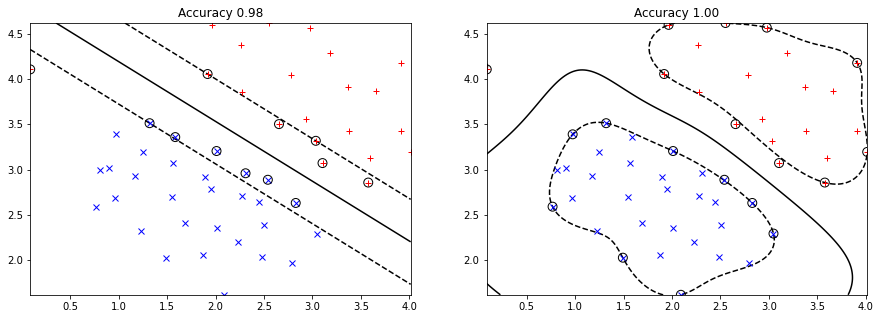

In [7]:
# Load the dataset
fname='data1.txt'
data = np.loadtxt('data/%s' % fname, delimiter=',')
 
X = data[:, 0:2] 
y = data[:, 2]

#Please insert your code for Task 3 here
C = [0.1,1,10,100]
sigma_values = [0.01,0.1,0.5,10]

sigma = sigma_values[2]


svc_linear = SVC(C = C[1], kernel="precomputed")
svc_linear.fit(linearKernel(X,X),y)

svc_gaussian = SVC(C = C[1], kernel="precomputed")
svc_gaussian.fit(gaussianKernel(X,X, sigma = sigma),y)


# Plot the decision boundary
u = np.linspace(min(X[:, 0]),max(X[:, 0]), 200)
v = np.linspace(min(X[:, 1]),max(X[:, 1]), 200)
z_linear = np.zeros(shape=(len(u), len(v)))
z_gaussian = np.zeros(shape=(len(u), len(v)))
for i in range(len(u)):
    for j in range(len(v)):
        x = np.array([[u[i],v[j]]])
        z_linear[i, j] = svc_linear.decision_function(linearKernel(x,X))
        z_gaussian[i, j] = svc_gaussian.decision_function(gaussianKernel(x,X,sigma))

        
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
ax[0].plot(X[:,0][y == 1], X[:,1][y == 1], 'r+', label="$y=1$")
ax[0].plot(X[:,0][y == 0], X[:,1][y == 0], 'bx', label="$y=0$")
ax[0].scatter(X[svc_linear.support_, 0], X[svc_linear.support_, 1], s=80, facecolors='none', zorder=10, edgecolor='k')
ax[0].contour(u, v, z_linear.T, levels = [-1,0,1], colors='k',linestyles=['--', '-', '--'])
ax[0].title.set_text('Accuracy %0.2f' %(np.sum(svc_linear.predict(linearKernel(X,X)) == y)/len(y)))

ax[1].plot(X[:,0][y == 1], X[:,1][y == 1], 'r+', label="$y=1$")
ax[1].plot(X[:,0][y == 0], X[:,1][y == 0], 'bx', label="$y=0$")
ax[1].scatter(X[svc_gaussian.support_, 0], X[svc_gaussian.support_, 1], s=80, facecolors='none', zorder=10, edgecolor='k')
ax[1].contour(u, v, z_gaussian.T, levels = [-1,0,1], colors='k',linestyles=['--', '-', '--'])
ax[1].title.set_text('Accuracy %0.2f' %(np.sum(svc_gaussian.predict(gaussianKernel(X,X,sigma)) == y)/len(y)))
plt.show()

## 2) Low Rank Approximation Using Non-Negative Matrix Factorisation (NMF)


Given a non-negative $n \times p$ data matrix $\mathbf{X}$ the non-negative matrix factorisation (NMF) algorithm finds non-negative matrix factors $\mathbf{A}\in R^{n\times r}$ and $\mathbf{B}\in R^{r\times p}$ such that, 
$$\mathbf{X}\approx \mathbf{A}\mathbf{B}.$$
This approximation is found by minimising the reconstruction error in Frobenius norm, i.e., 
$$\Vert \mathbf{X}-\mathbf{A}\mathbf{B} \Vert_F=\sqrt{\sum_{i=1}^n\sum_{j=1}^p \left(\mathbf{X}_{ij}-(\mathbf{AB})_{ij}\right)^2}$$
Hence, our optimisation problem is to: *Minimise* $\Vert \mathbf{X}-\mathbf{AB}\Vert_F$ with respect to $\mathbf{A}$ and $\mathbf{B}$, subject to the constraints $\mathbf{A},\mathbf{B}\ge0,$ (i.e.,$A_{ia}, B_{aj} \ge0$ for  $i \in \{1, \ldots n\},$ $j \in \{1, \ldots, p\}$ and $a\in \{1, \ldots, r\}$).
One way to find minima of this cost function is by using the following "multiplicative update rules," 



$$\mathbf{B}^{(k+1)}_{aj} =  \mathbf{B}^{(k)}_{aj}  \frac{(\mathbf{A}^{(k) ~T} \mathbf{X})_{aj}}{(\mathbf{A}^{(k)~T} \mathbf{A}^{(k)}\mathbf{B}^{(k)})_{aj}}$$

$$\mathbf{A}^{(k+1)}_{ia} = \mathbf{A}^{(k)}_{ia}\frac{(\mathbf{X} \mathbf{B}^{(k+1)~T})_{ia}}{(\mathbf{A}^{(k)}\mathbf{B}^{(k+1)}\mathbf{B}^{(k+1)~T})_{ia}},$$


where $i \in \{1, \ldots n\},$ $j \in \{1, \ldots, p\}$ and $a\in \{1, \ldots, r\}.$
The difference in Frobenius norm  $\Vert \mathbf{X}-\mathbf{AB}\Vert_F$ can be shown to be  is nonincreasing when calculating $\mathbf{A}$ and $\mathbf{B}$ using the update rules.

We need to initialise $\mathbf{A}^{(0)}$ and $\mathbf{B}^{(0)}$ to be non-negative. A simplistic approach would be to use random non-negative matrices. However, a more efficient and sophisticated method utilises the [SVD decompostition](http://theanalysisofdata.com/probability/C_5.html#:~:text=5.2.,are%20square%20non%2Dsingular%20matrices.) of the matrix $\mathbf{X}_{n \times p} = \mathbf{V}_{n \times r} \mathbf{\Sigma}_{r \times r} \mathbf{W^T}_{r \times p}$ by setting $\mathbf{A}^{(0)}_{ij}=\vert \mathbf{V}_{ij}\vert$ and $\mathbf{B}^{(0)}_{ij}=\vert \mathbf{W}_{ji}\vert$.







### Dataset

In this part of the lab we will work with a dataset of 8447 New York Times articles. For each of these articles the dataset contains the word counts of 3012 words. The aim will be to use the NMF algorithm to extract topics of these articles. 

Our data matrix $\mathbf{X}$ will be a term/document matrix, where each row corresponds to a term (or word) and each feature is its occurence in the given document.  


Each entry $\mathbf{A}_{ij}$ will be indicative of the impact of the word $i$ for the extracted feature $j$. Here we hope that the extracted features correspond to topics discussed in the articles. In order to recognise topics, we will observe the $t$ words with highest weight for every column of $\mathbf{A}$.  


We begin by loading the dataset. Note that we are only working with the first 1000 articles in the dataset to keep computation time short. But feel free to increase the $\texttt{numDoc}$ if you want to analyse a larger proportion of the dataset.

In [8]:
with open('data/nyt_data.txt') as f:
    documents = f.readlines()
documents = [x.strip().strip('\n').strip("'") for x in documents]

with open('data/nyt_vocab.dat') as f:
    vocabs = f.readlines()
vocabs = [x.strip().strip('\n').strip("'") for x in vocabs]


numDoc = 1000
numWord = 3012
X = np.zeros((numWord,numDoc))

for doc in range(numDoc):
    for word_occurence in documents[doc].split(','):
        X[int(word_occurence.split(':')[0])-1,doc] = float(word_occurence.split(':')[1])

X=X+np.ones((numWord,numDoc))*0.00000001



>**Task 4:** Implement the NMF algorithm by completing the $\texttt{nmf}\_\texttt{factor}$ function.


In [9]:
def nmf_factor(X, r, iterations=100):
    """
    Args:
        X (np.array): data matrix
        r (int): number of features to be extracted using the NMF algorithm
        iterations (int): max number of iterations for which to run the update rules
        
    Returns:
        A (np.array): the first of the two NMF factors
        B (np.array): the second of the two NMF factors
        normalised_cost (np.array): return the cost function normalised by the Frobenius norm of X (calculated at each update iteration) 
    """
    
    n,m = X.shape
    normalised_cost=np.zeros(iterations)

    # Please insert the code for Task 4 here 
    
    A_0, S, B_0 = np.linalg.svd(X, full_matrices=False)
    A = np.abs(A_0[:,:r])
    B = np.abs(B_0[:r,:])
    
    for i in range(iterations):
        B = B * (A.T@X)/(A.T@A@B)
        A = A * (X@B.T)/(A@B@B.T)
    
        normalised_cost[i] = np.linalg.norm(X-A@B)/np.linalg.norm(X)
    
    return A, B, normalised_cost


Run your implemented NMF approximation on the New York Times article dataset and observe whether the extracted factors can indeed be interpreted as topics in articles.

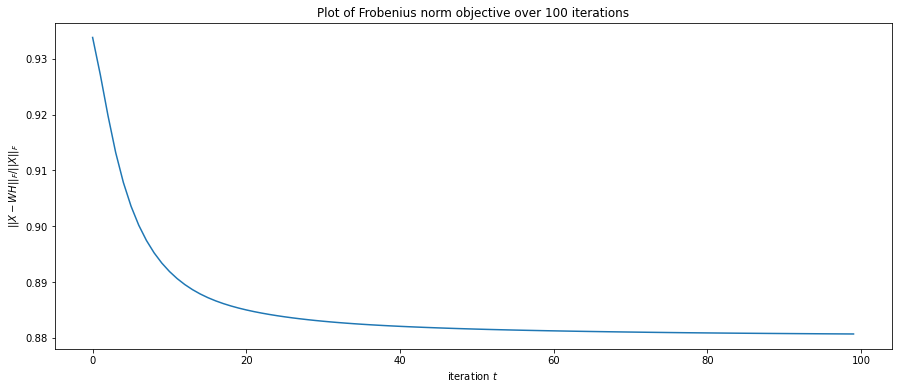


    Topic 1    Weight     Topic 2    Weight     Topic 3    Weight
0    thing  0.014115        life  0.011013     company  0.022582
1     feel  0.011648        play  0.009580    business  0.013317
2     tell  0.008926       write  0.009279       stock  0.012141
3   happen  0.008534   character  0.008032       share  0.011480
4   little  0.008178         man  0.007613   executive  0.011459
5      put  0.008162        love  0.007278      market  0.009919
6  problem  0.007902        film  0.006986        sell  0.009138
7      lot  0.007689       movie  0.005836       chief  0.008300
8      ask  0.006959  television  0.005747  investment  0.007946
9   change  0.006864        book  0.005576    investor  0.007530 


   Topic 4    Weight    Topic 5    Weight  Topic 6    Weight
0    game  0.016695        ask  0.004142   police  0.017876
1    team  0.013429   question  0.004025      man  0.013258
2    play  0.013380       jury  0.003922   charge  0.010522
3     win  0.012515       case  0.00386

In [10]:

A,B,normalised_cost=nmf_factor(X,18)

plt.figure(figsize = (15,6))
plt.plot(range(len(normalised_cost)),normalised_cost)
plt.title('Plot of Frobenius norm objective over 100 iterations')
plt.ylabel('$||X-WH||_F/||X||_F$')
plt.xlabel('iteration $t$')
plt.show()



#normalize each column to sum to one
A_normed = A / np.sum(A,axis=0)

#for each column of W, list the 10 words having the largest weight and show the weight
vList = []

for topic in range(18):
    v = pd.DataFrame(vocabs)
    v[1] = A_normed[:,topic].round(6)
    v = v.sort_values([1, 0], ascending=[0,1]).rename(index=int, columns={0: "Topic {}".format(topic+1), 1: "Weight"}).head(10)
    v = v.reset_index(drop=True)
    vList.append(v)


for num in np.arange(6):
    print('\n',(pd.concat(vList[num*3:(num+1)*3], axis=1)),'\n')
